<a href="https://colab.research.google.com/github/pvpogorelova/metrics_24_25/blob/main/%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80%2015.%20%D0%98%D0%BD%D1%81%D1%82%D1%80%D1%83%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BF%D0%B5%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Семинар 15. Эндогенность.**


In [ ]:
# для работы с данными
import pandas as pd
import numpy as np

# всякие статистики
from scipy import stats
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

# быстрый вызов эконометрических команд
import statsmodels.api as sm

!pip install linearmodels
from linearmodels.iv import IV2SLS, compare
from linearmodels.shared.hypotheses import WaldTestStatistic as wald_test

# графики
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
%matplotlib inline

# убрать предупреждения
import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 862.9 kB/s eta 0:00:00


### Практическое применение метода инструментальных переменных

Исследование влияния образования на заработную плату часто основывается на модели

$ln(W_i) = \theta_1 + \theta_2 Schooling_i + \theta_3 Experience_i + \theta_4 Eхperience_i^2 + \varepsilon_i$,

где $W_i$ – размер часовой заработной платы i-го индивида, $S_i$ – продолжительность его образования, $E_i$ – стаж его практической работы. В правую часть обычно также включаются некоторые дополнительные переменные, учитывающие расовые, половые и другие различия между индивидами.


Достаточно ли такой модели для объяснения зп?

-- дефицит кадров

-- продолжительность рабочего дня

-- срок давности диплома

-- интеллект (IQ???)

-- эрудиция


Когда возникает смещение оценки $\theta_2$?

-- ошибки измерения (не от нас зависят)

-- смещение из-за пропущенной переменной, если она коррелирует с продолжительностью обучения -- возможно, да


Проблема: в модели присутствует эндогенность (остатки коррелируют с регрессорами)

Коэффициент $\theta_2$ трактуется как средний процент увеличения заработной платы от дополнительного года образования и представляет особый интерес. При этом предполагается, что некоторые, не включенные в спецификацию уравнения, факторы коррелированы с $E_i$ и $S_i$, так что использование для оценивания модели обычного метода наименьших квадратов приводит к смещенной оценке коэффициента $\theta_2$.

В файле schooling.csv содержатся данные по выборке мужчин, имевших в 1966 г. возраст от 14 до 24 лет, и проинтервьюированных в 1976 г.

Оцените по эти данным уравнение

$ln(W_i) = \theta_1 + \theta_2 S_i + \theta_3 E_i + \theta_4 E_i^2 + \theta_5 BLACK_i + \theta_6 SMSA_i + \theta_7 SOUTH_i + \varepsilon_i$,

где BLACK, SMSA, SOUTH – дамми-переменные, выделяющие темнокожих американцев, лиц, проживающих в крупных городах и в южных штатах США.

In [3]:
data = pd.read_csv('schooling.csv')
data.head()

,AGE,AGE2,BLACK,EXP,EXP2,LWAGE,NEARC,SCHOOLING,SMSA,SOUTH,FATHEDUC,MOTHEDUC
0,29,841,1,16,256,6.306275,0,7,1,0,NaN,NaN
1,27,729,0,9,81,6.175867,0,12,1,0,8.0,8.0
2,34,1156,0,16,256,6.580639,0,12,1,0,14.0,12.0
3,27,729,0,10,100,5.521461,1,11,1,0,11.0,12.0
4,34,1156,0,16,256,6.591674,1,12,1,0,8.0,7.0


In [4]:
data.describe()

,AGE,AGE2,BLACK,EXP,EXP2,LWAGE,NEARC,SCHOOLING,SMSA,SOUTH,FATHEDUC,MOTHEDUC
count,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,2320.000000,2657.000000
mean,28.119601,800.549502,0.233555,8.856146,95.579070,6.261832,0.682060,13.263455,0.712957,0.403654,10.003448,10.348137
std,3.137004,180.748395,0.423162,4.141672,84.618314,0.443798,0.465753,2.676913,0.452457,0.490711,3.720737,3.179671
min,24.000000,576.000000,0.000000,0.000000,0.000000,4.605170,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,625.000000,0.000000,6.000000,36.000000,5.976985,0.000000,12.000000,0.000000,0.000000,8.000000,8.000000
50%,28.000000,784.000000,0.000000,8.000000,64.000000,6.286928,1.000000,13.000000,1.000000,0.000000,10.000000,12.000000
75%,31.000000,961.000000,0.000000,11.000000,121.000000,6.563503,1.000000,16.000000,1.000000,1.000000,12.000000,12.000000
max,34.000000,1156.000000,1.000000,23.000000,529.000000,7.784889,1.000000,18.000000,1.000000,1.000000,18.000000,18.000000


In [5]:
data[['SCHOOLING', 'EXP', 'EXP2', 'BLACK', 'SMSA', 'SOUTH']].corr()

,SCHOOLING,EXP,EXP2,BLACK,SMSA,SOUTH
SCHOOLING,1.000000,-0.652956,-0.631521,-0.269388,0.187579,-0.201411
EXP,-0.652956,1.000000,0.967202,0.139209,-0.135722,0.111650
EXP2,-0.631521,0.967202,1.000000,0.134726,-0.140540,0.118649
BLACK,-0.269388,0.139209,0.134726,1.000000,-0.036813,0.341267
SMSA,0.187579,-0.135722,-0.140540,-0.036813,1.000000,-0.184474
SOUTH,-0.201411,0.111650,0.118649,0.341267,-0.184474,1.000000


                            OLS Regression Results                            
Dep. Variable:                  LWAGE   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     204.9
Date:                Fri, 24 Jan 2025   Prob (F-statistic):          1.52e-219
Time:                        08:45:47   Log-Likelihood:                -1308.7
No. Observations:                3010   AIC:                             2631.
Df Residuals:                    3003   BIC:                             2673.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7337      0.068     70.022      0.0

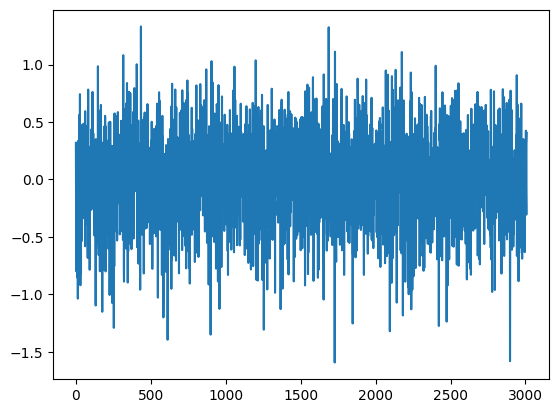

In [6]:
wage = data.LWAGE
factors = sm.add_constant(data[['SCHOOLING', 'EXP', 'EXP2', 'BLACK', 'SMSA', 'SOUTH']])

res = sm.OLS(wage, factors).fit()

print(res.summary())

plt.plot(res.resid)
plt.show()

Получается, что при прочих равных год обучения добавляет 7.4% к зп

1) нужно убрать эндогенность (плохая), оставив всё полезное

z -- инструмент, релевантный (corr(s, z) высока)  и экзогенный (corr(epsilon, z)) близка к 0)

s ~ все экзогенные регрессоры (black etc) и на все

оставим только $\hat(s)$ -- экзогенная

2) оценить lwage ~ экзогенные регрессоры и очищенные на 1 шаге эндогенные регресоры

Сравните результаты применения обычного метода наименьших квадратов и двухшагового метода наименьших квадратов, использующего в качестве инструмента для $S_i$ переменную $NEARC_i$, где $NEARC_i$ равна 1, если индивид в 1966 г. проживал недалеко от колледжа c 4-летним курсом обучения.

In [7]:
data['const'] = np.ones_like(data['LWAGE'])

In [8]:
# OLS
iv = IV2SLS(dependent = data['LWAGE'],
            exog = data[['const', 'SCHOOLING', 'EXP', 'EXP2', 'BLACK', 'SMSA', 'SOUTH']],
            endog = None,
            instruments = None).fit()

print(iv.summary)

                            OLS Estimation Summary                            
Dep. Variable:                  LWAGE   R-squared:                      0.2905
Estimator:                        OLS   Adj. R-squared:                 0.2891
No. Observations:                3010   F-statistic:                    1309.5
Date:                Fri, Jan 24 2025   P-value (F-stat)                0.0000
Time:                        08:46:36   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.7337     0.0701     67.550     0.0000      4.5963      4.8710
SCHOOLING      0.0740     0.0036     20.344     0.00

In [11]:
# 1 шаг: очистка эндогенной переменной

# SCHOOLING
iv_1 = IV2SLS(dependent = data['SCHOOLING'],
            exog = data[['const', 'EXP', 'EXP2', 'BLACK', 'SMSA', 'SOUTH', 'NEARC']],
            endog = None,
            instruments = None).fit()
print(iv_1.summary)
data["SCH_hat"] = data['SCHOOLING'] - iv_1.resids

                            OLS Estimation Summary                            
Dep. Variable:              SCHOOLING   R-squared:                      0.4745
Estimator:                        OLS   Adj. R-squared:                 0.4734
No. Observations:                3010   F-statistic:                    3656.6
Date:                Fri, Jan 24 2025   P-value (F-stat)                0.0000
Time:                        08:47:41   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          16.659     0.1466     113.66     0.0000      16.372      16.946
EXP           -0.4100     0.0319    -12.836     0.00

In [12]:
# 1 шаг
dependent = data['SCHOOLING']
exog = data[['const', 'EXP', 'EXP2', 'BLACK', 'SMSA', 'SOUTH', 'NEARC']]

mod = sm.OLS(dependent, exog)
res = mod.fit()

print(res.summary())

# релевантность
hypotheses = '(NEARC = 0)'
f_test = res.f_test(hypotheses)
print(f_test)

                            OLS Regression Results                            
Dep. Variable:              SCHOOLING   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     451.9
Date:                Fri, 24 Jan 2025   Prob (F-statistic):               0.00
Time:                        08:47:54   Log-Likelihood:                -6266.1
No. Observations:                3010   AIC:                         1.255e+04
Df Residuals:                    3003   BIC:                         1.259e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.6592      0.176     94.446      0.0

In [13]:
# 2 шаг: регрессия с инструментами
iv_2 = IV2SLS(dependent = data['LWAGE'],
            exog = data[['const', 'SCH_hat', 'EXP', 'EXP2', 'BLACK', 'SMSA', 'SOUTH']],
            endog = None,
            instruments = None).fit()
print(iv_2.summary)

                            OLS Estimation Summary                            
Dep. Variable:                  LWAGE   R-squared:                      0.1871
Estimator:                        OLS   Adj. R-squared:                 0.1854
No. Observations:                3010   F-statistic:                    749.20
Date:                Fri, Jan 24 2025   P-value (F-stat)                0.0000
Time:                        08:48:32   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          3.7528     0.8171     4.5929     0.0000      2.1513      5.3542
SCH_hat        0.1323     0.0485     2.7275     0.00

Теперь доп год при прочих равных увеличивает зп примерно на 13%

In [14]:
iv_2sls = IV2SLS(dependent = data['LWAGE'],
            exog = data[['const', 'EXP', 'EXP2', 'BLACK', 'SOUTH', 'SMSA']],
            endog = data['SCHOOLING'],
            instruments = data[['NEARC']]).fit()

print(iv_2sls.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  LWAGE   R-squared:                      0.2252
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2237
No. Observations:                3010   F-statistic:                    792.07
Date:                Fri, Jan 24 2025   P-value (F-stat)                0.0000
Time:                        08:48:59   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          3.7528     0.8167     4.5948     0.0000      2.1520      5.3536
EXP            0.1075     0.0211     5.0916     0.00

In [15]:
print(compare({"OLS": iv, "2nd step": iv_2, "TSLS": iv_2sls}))

                       Model Comparison                       
                               OLS      2nd step          TSLS
--------------------------------------------------------------
Dep. Variable                LWAGE         LWAGE         LWAGE
Estimator                      OLS           OLS       IV-2SLS
No. Observations              3010          3010          3010
Cov. Est.                   robust        robust        robust
R-squared                   0.2905        0.1871        0.2252
Adj. R-squared              0.2891        0.1854        0.2237
F-statistic                 1309.5        749.20        792.07
P-value (F-stat)            0.0000        0.0000        0.0000
==================     ===========   ===========   ===========
const                       4.7337        3.7528        3.7528
                          (67.550)      (4.5929)      (4.5948)
SCHOOLING                   0.0740                      0.1323
                          (20.344)                    (

Три повода усмниться в инструментах

1) экзогенные?
2) релевантные?
3) s -- эндогенный?

Можно ли здесь провести проверку на пригодность использованных инструментов (1-2 вопросы)?

тест Саргана! (можно использовать, только если есть разные наборы инструментов -- инструментов больше, чем эндогенных)

In [16]:
data_sh = data.dropna()

# просто так :)
data_sh = data_sh[0:len(data_sh)-1]

data_sh.tail()

,AGE,AGE2,BLACK,EXP,EXP2,LWAGE,NEARC,SCHOOLING,SMSA,SOUTH,FATHEDUC,MOTHEDUC,const,SCH_hat
2997,30,900,1,8,64,6.240276,1,16,1,1,16.0,16.0,1.0,12.869572
2998,30,900,1,11,121,6.270988,1,13,1,0,4.0,9.0,1.0,11.972752
3000,27,729,0,8,64,6.214608,1,13,0,1,6.0,8.0,1.0,13.471833
3001,29,841,0,8,64,6.568078,1,15,1,1,16.0,18.0,1.0,13.875710
3002,27,729,0,5,25,6.156979,1,16,1,1,16.0,18.0,1.0,15.077175


Заметим, что мы можем привлечь в качестве дополнительных инструментов для переменной $schooling$ также содержащиеся в базе данных переменные $fatheduc$ и $motheduc$, отражающие длительность образования родителей. Поскольку значения этих переменных известны не для всех наблюдений, при оценивании будут использоваться только полные наблюдения.

In [17]:
iv_2sls = IV2SLS(dependent = data_sh['LWAGE'],
            exog = data_sh[['const', 'EXP', 'EXP2', 'BLACK', 'SOUTH', 'SMSA']],
            endog = data_sh[['SCHOOLING']],
            instruments = data_sh[['NEARC', 'FATHEDUC','MOTHEDUC']]).fit()

print(iv_2sls.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  LWAGE   R-squared:                      0.2523
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2503
No. Observations:                2219   F-statistic:                    550.49
Date:                Fri, Jan 24 2025   P-value (F-stat)                0.0000
Time:                        08:50:08   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.2608     0.2244     18.988     0.0000      3.8210      4.7006
EXP            0.0990     0.0096     10.311     0.00

Доп год образования приводит к росту зп примерно на 10%

Проверим предпосылку о релевантности (высокая корреляция инструментов с эндогенными переменными)

In [18]:
# 1 шаг
dependent = data_sh['SCHOOLING']
exog = data_sh[['const', 'EXP', 'EXP2', 'BLACK', 'SMSA', 'SOUTH', 'NEARC', 'MOTHEDUC', 'FATHEDUC']]

mod = sm.OLS(dependent, exog)
res = mod.fit()

print(res.summary())

hypotheses = '(NEARC = MOTHEDUC = FATHEDUC= 0)'
f_test = res.f_test(hypotheses)
print(f_test)

                            OLS Regression Results                            
Dep. Variable:              SCHOOLING   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     257.9
Date:                Fri, 24 Jan 2025   Prob (F-statistic):          8.78e-310
Time:                        08:51:01   Log-Likelihood:                -4526.5
No. Observations:                2219   AIC:                             9071.
Df Residuals:                    2210   BIC:                             9122.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.7965      0.270     51.153      0.0

F_stat > 10, то инструменты релевантные

In [19]:
iv_2sls.sargan

Sargan's test of overidentification
H0: The model is not overidentified.
Statistic: 2.0802
P-value: 0.3534
Distributed: chi2(2)
WaldTestStatistic, id: 0x7e81b28e8a10

3 инструмента подобраны верно, оценка отдачи от образования в 10%, предположительно не смещена

Посмотрим теперь на всё проделанное с точки зрения методологии эконометрического исследования, о которой говорилось на лекции.

Почему мы выбрали для оценивания метод инструментальных переменных (2SLS=TSLS)? Потому что в литературе обычно указывается на наличие в рассматриваемой модели одной эндогенной переменной, и 2SLS выбирается, чтобы предотвратить несостоятельность оценок коэффициентов, полученных OLS.

Но действительно ли образование является эндогенной переменной?

Можно провести тест, позволяющий дать ответ на этот вопрос (тест на эндогенность). Проведем проверку на возможную экзогенность переменной $SCHOOLING$, используя тот же расширенный набор инструментов. Для этого после оценивания модели проводим тест Хаусмана:

3) эндогенность образования -- тест Хаусмана

In [22]:
iv_2sls = IV2SLS(dependent = data_sh['LWAGE'],
            exog = data_sh[['const', 'EXP', 'EXP2', 'BLACK', 'SOUTH', 'SMSA']],
            endog = data_sh[['SCHOOLING']],
            instruments = data_sh[['NEARC', 'FATHEDUC','MOTHEDUC']]).fit()

print(iv_2sls.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  LWAGE   R-squared:                      0.2523
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2503
No. Observations:                2219   F-statistic:                    550.49
Date:                Fri, Jan 24 2025   P-value (F-stat)                0.0000
Time:                        08:55:06   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.2608     0.2244     18.988     0.0000      3.8210      4.7006
EXP            0.0990     0.0096     10.311     0.00

In [23]:
iv_2sls.wu_hausman(['SCHOOLING'])

Wu-Hausman test of exogeneity
H0: Variables SCHOOLING are exogenous
Statistic: 4.2868
P-value: 0.0385
Distributed: F(1,2211)
WaldTestStatistic, id: 0x7e81b04784d0

Так как p-value=0.0385 < 0.05, то Н0 отвергается на 5% уровне значимости. Следовательно, образование скорее всего является эндогенной переменной. Для получения состоятельных оценок следует выбрать iv (2sls)

1) слабость инструментов (F_stat < 10 на первом шаге)
2) тест Срагана (только если инструментов много) -- хороший ли набор
3) тест Хаусмана на необходимость инструментов вообще